# Triage Workflow Run Error

This notebook will look through Tibanna's StepFunction interface on AWS, shows some graphs, then determine the last failed execution and show you what the error for the last execution was.


In [1]:
# first we just load up some stuff
# %load init.py
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from core import utils
import boto3
import json
pd.set_option('display.max_columns',100);pd.set_option('display.max_rows',1000)
%matplotlib inline


/Users/j1z0/.virtualenvs/27wranglers/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# Connect to AWS and see what's going on
client = boto3.client('stepfunctions', region_name='us-east-1')
base_arn = 'arn:aws:states:us-east-1:643366669028:%s:%s'
STEP_FUNCTION_ARN = base_arn % ('stateMachine', 'run_sbg_workflow_2')

executions = client.list_executions(stateMachineArn=STEP_FUNCTION_ARN, maxResults=1000)
exec_df = pd.DataFrame(executions.get('executions'))
exec_df.sort_values(by='startDate', ascending=False, inplace=True)
exec_df.head()






,executionArn,name,startDate,stateMachineArn,status,stopDate
0,arn:aws:states:us-east-1:643366669028:executio...,testrun_20170526153220732809,2017-05-26 15:32:20.886000-04:00,arn:aws:states:us-east-1:643366669028:stateMac...,ABORTED,2017-05-26 15:32:21.156000-04:00
1,arn:aws:states:us-east-1:643366669028:executio...,testrun_20170526152854658288,2017-05-26 15:28:54.841000-04:00,arn:aws:states:us-east-1:643366669028:stateMac...,ABORTED,2017-05-26 15:28:55.071000-04:00
2,arn:aws:states:us-east-1:643366669028:executio...,generic_bdaaaff5-6ecf-42fe-b3f4-065915be8a43,2017-05-26 15:23:26.317000-04:00,arn:aws:states:us-east-1:643366669028:stateMac...,RUNNING,NaT
9,arn:aws:states:us-east-1:643366669028:executio...,fastqc-0-11-4-1-1_4DNFIX2YOM48.fastq.gza33f09d...,2017-05-26 10:40:10.283000-04:00,arn:aws:states:us-east-1:643366669028:stateMac...,SUCCEEDED,2017-05-26 11:11:32.918000-04:00
51,arn:aws:states:us-east-1:643366669028:executio...,fastqc-0-11-4-1-1_4DNFI7JKBOM7.fastq.gz,2017-05-26 10:40:04.584000-04:00,arn:aws:states:us-east-1:643366669028:stateMac...,RUNNING,NaT


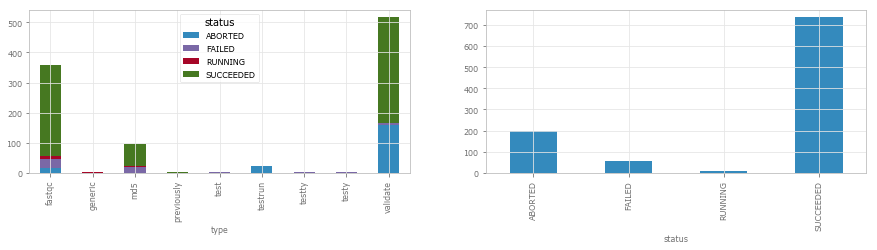

In [3]:
#clean up the names of runs so we can better group things for graphing

to_replace = ['fastqc*', 'validate*', 'test*']
value = ['fastqc', 'validate', 'testing']
exec_df['type'] = exec_df.name.replace(to_replace='[-,_].*$', value='', regex=True, inplace=False)


fig, axs = plt.subplots(1,2, figsize=(15,3))

group_by_status = exec_df.groupby(['type', 'status'])
group_by_status.size().unstack().plot(kind='bar', stacked=True, ax=axs[0])

overview = exec_df.groupby(['status'])
overview.size().plot(kind='bar', stacked=True, ax=axs[1])


Now onto the diagnostics.  Below you can use num_days to shorten the length of the query which will show you all the errors found in that time period.

In [4]:
# Failures in last num_days
num_days = 10
import datetime
cutoff = datetime.datetime.today() - datetime.timedelta(days=10) 
latest = exec_df.loc[(exec_df.startDate > cutoff) & (exec_df.status.apply(lambda x: x in ['FAILED',]))]
print("%s errors found for all step functions since %s" % 
      (len(latest), cutoff.date()))

27 errors found for all step functions since 2017-05-20


By default we will get the most recent error, but you can set exec_name if you want to look at a particular execution.

In [5]:
# by default though we get the most recent errror
exec_name = latest.iloc[0]['name']

# use to view errors for a specific step-function run result
# exec_name = 'fastqc-0-11-4-1-1_4DNFIWJZJ6JS.fastq.gz'

def get_exec_arn(name):
    try:
        return latest.loc[latest.name == name, 'executionArn'].iloc[0]
    except:
        print("run %s not found " % name)
        return ''
       
def get_exec_url(name):
    try:
        arn = latest.loc[latest.name == name, 'executionArn'].iloc[0]
        baseurl = 'https://console.aws.amazon.com/states/home?region=us-east-1#/executions/details/'
        return '%s%s' % (baseurl, arn)
    except:
        print("run %s not found" % name)
        return ''
    
url = get_exec_url(exec_name)
arn = get_exec_arn(exec_name)
print("you can view the url for the failing run by clicking on the link below:\n")
print(url)

you can view the url for the failing run by clicking on the link below:

https://console.aws.amazon.com/states/home?region=us-east-1#/executions/details/arn:aws:states:us-east-1:643366669028:execution:run_sbg_workflow_2:fastqc-0-11-4-1-1_4DNFIWJZJ6JS.fastq.gz


In [6]:
# now let's see which lambda for the run failed
resp = client.get_execution_history(executionArn=arn, reverseOrder=True)

for i, event in enumerate(resp.get('events')):
    if event.get('type') == 'LambdaFunctionScheduled':
        break
failing_lambda = resp.get('events')[:i+1]
lambda_arn = failing_lambda[-1]['lambdaFunctionScheduledEventDetails']['resource']
input_json = failing_lambda[-1]['lambdaFunctionScheduledEventDetails']
lambda_time = failing_lambda[-1]['timestamp']
failure = failing_lambda[0].get('executionFailedEventDetails')
if failure is None:
    failure = failing_lambda[0].get('executionAbortedEventDetails')

print("lambda %s \nRunning at %s failed \nFailure is %s" % 
      (lambda_arn, str(lambda_time), failure))
print
print
print("input json for the lambda was:") 
print
print(input_json)


lambda arn:aws:lambda:us-east-1:643366669028:function:start_run_sbg 
Running at 2017-05-25 10:40:18.830000-04:00 failed 
Failure is {u'cause': u'{"stackTrace": [["/var/task/service.py", 116, "handler", "raise Exception(\\"Unable to mount output volume, error is %s \\" % res)"]], "errorType": "Exception", "errorMessage": "Unable to mount output volume, error is {u\'status\': 403, u\'message\': u\'Could not obtain cross-write access on the service. Check the documentation.\', u\'code\': 9002, u\'more_info\': u\'http://docs.sevenbridges.com/docs/api-status-codes#9002\'} "}', u'error': u'Exception'}


input json for the lambda was:

{u'input': u'{"app_name": "fastqc-0-11-4-1/1", "parameters": {}, "_tibanna": {"run_type": "fastqc-0-11-4-1/1", "run_id": "4DNFIWJZJ6JS.fastq.gz", "url": "https://console.aws.amazon.com/states/home?region=us-east-1#/executions/details/arn:aws:states:us-east-1:643366669028:execution:run_sbg_workflow_2:fastqc-0-11-4-1-1_4DNFIWJZJ6JS.fastq.gz", "env": "fourfront-we

In [7]:
json.loads(failure['cause'])['errorMessage']

u"Unable to mount output volume, error is {u'status': 403, u'message': u'Could not obtain cross-write access on the service. Check the documentation.', u'code': 9002, u'more_info': u'http://docs.sevenbridges.com/docs/api-status-codes#9002'} "

Some of the checks below should help identify common problems, such as file doesn't exist...

In [8]:
# TODO: ensure workflow exists on target server

# TODO: check the input files exists on s3

# TODO: validate input for step
